# load emnist samples and adjust data

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn import linear_model, preprocessing
#from matplotlib import pyplot
from scipy import ndimage, misc
import skimage.transform
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import tensorflow as tf

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [43]:
def asc(y):
    y=np.argmax(y,axis=0)
    if y<10:
        ascii=48+y
    else:
        ascii=87+y
    return chr(ascii)

In [3]:
import scipy.io
def load_emnist(file_path='emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

In [4]:
Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist()
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist(file_path='emnist-letters.mat')

240000 training samples, 40000 test samples loaded
124800 training samples, 20800 test samples loaded


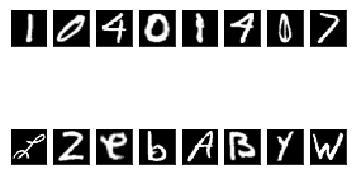

In [5]:
def plt_digit(x,y=None):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq.T,  cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])    
    if y != None:
        plt.title('%d' % y)     
        
nplt = 8
nsamp = Xtr_dig.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(2,nplt,i+1)
    plt_digit(Xtr_dig[ind,:])
    
nplt = 8
nsamp = Xtr_let.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
for i in range(nplt):
    ind = Iperm[i]
    plt.subplot(2,nplt,i+1+nplt)
    plt_digit(Xtr_let[ind,:])

In [6]:
Xtrd=np.reshape(Xtr_dig,(240000,28,28),order='F')
Xtsd=np.reshape(Xts_dig,(40000,28,28),order='F')
Xtrl=np.reshape(Xtr_let,(124800,28,28),order='F')
Xtsl=np.reshape(Xts_let,(20800,28,28),order='F')


In [7]:
# dig: 240000 training samples, 40000 test samples loaded
# let: 124800 training samples, 20800 test samples loaded
# Number of training and test digits and letters
ntr_dig = 5000
ntr_let = 20000
nts_dig = 5000
nts_let = 20000
# TODO: properly decide the number of samples and the ratio between dig and let

# Create sub-sampled training and test data
nsamp = Xtr_dig.shape[0]
Iperm = np.random.permutation(nsamp)
Xtr1_dig = Xtrd[Iperm[:ntr_dig],:,:]
ytr1_dig = ytr_dig[Iperm[:ntr_dig]]
nsamp = Xts_dig.shape[0]
Iperm = np.random.permutation(nsamp)
Xts1_dig = Xtsd[Iperm[:nts_dig],:,:]
yts1_dig = yts_dig[Iperm[:nts_dig]]
nsamp = Xtr_let.shape[0]
Iperm = np.random.permutation(nsamp)
Xtr1_let = Xtrl[Iperm[:ntr_let],:,:]
ytr1_let = ytr_let[Iperm[:ntr_let]]
nsamp = Xts_let.shape[0]
Iperm = np.random.permutation(nsamp)
Xts1_let = Xtsl[Iperm[:nts_let],:,:]
yts1_let = yts_let[Iperm[:nts_let]]

In [8]:
ytr2_let=ytr1_let+9
yts2_let=yts1_let+9
x_train=np.concatenate((Xtr1_dig, Xtr1_let), axis=0)
y_train=np.concatenate((ytr1_dig, ytr2_let), axis=0)
y_train=y_train.reshape((len(y_train),1))
x_test=np.concatenate((Xts1_dig, Xts1_let), axis=0)
y_test=np.concatenate((yts1_dig, yts2_let), axis=0)
y_test=y_test.reshape((len(y_test),1))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
x_train=x_train.reshape((ntr_dig+ntr_let,28,28,1))
x_test=x_test.reshape((nts_dig+nts_let,28,28,1))
x_train=np.concatenate((x_train,x_train,x_train), axis=3)
x_test=np.concatenate((x_test,x_test,x_test), axis=3)

In [9]:
#print(x_train)
print(x_train.shape)
print(y_train)
print(y_train.shape)

(25000, 28, 28, 3)
[[ 8]
 [ 4]
 [ 2]
 ...
 [14]
 [30]
 [13]]
(25000, 1)


In [10]:
nrow,ncol=56,56
#sess = tf.InteractiveSession()
#xtr48=tf.image.resize_images(x_train,(nrow,ncol)).eval()
#xts48=tf.image.resize_images(x_test,(nrow,ncol)).eval()
xtr56=np.zeros((x_train.shape[0],nrow,ncol,x_train.shape[3]))
for i in range(x_train.shape[0]):
    for j in range(3):
        img=x_train[i,:,:,j]
        img2 = ndimage.zoom(img, 2.0)
        xtr56[i,:,:,j]=img2
xts56=np.zeros((x_test.shape[0],nrow,ncol,x_test.shape[3]))
for i in range(x_test.shape[0]):
    for j in range(3):
        img=x_test[i,:,:,j]
        img2 = ndimage.zoom(img, 2.0)
        xts56[i,:,:,j]=img2

In [37]:
print(xtr56.shape)
print(type(xtr56))

(25000, 56, 56, 3)
<class 'numpy.ndarray'>


In [36]:
num_classes=36
ytrc = keras.utils.to_categorical(y_train, num_classes)
ytsc = keras.utils.to_categorical(y_test, num_classes)

In [38]:
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10.0,
                                   horizontal_flip=False)
train_generator = train_datagen.flow(xtr56,y=ytrc)

In [39]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                  rotation_range=10.0,
                                   horizontal_flip=False)
test_generator = test_datagen.flow(xts56,y=ytsc)

In [40]:
# Display the image
def disp_image(im):
    if ((im.shape[2]) == 1):
        # Gray scale image
        im=np.reshape(im,(28,28))
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

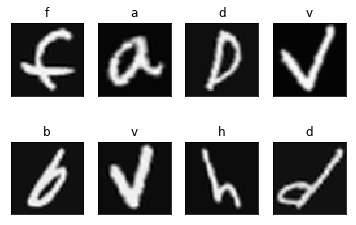

In [47]:
Xnext,ynext=train_generator.next()
for i,img in enumerate(Xnext):
    plt.subplot(2,4,i+1)
    disp_image(img)
    plt.title(asc(ynext[i]))
    if i==7:
        break

## training VGG model

In [62]:
from __future__ import print_function
# from keras.datasets import cifar10
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model #save and load models
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from keras.models import Model

In [63]:
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions, preprocess_input 
import keras.backend as K

In [84]:
#K.clear_session()
#base_model = VGG16(include_top=True,weights='imagenet',input_shape=((224,224,3)))
#base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [78]:
K.clear_session()
base_model = VGG16(include_top=False,weights='imagenet',input_shape=((nrow,ncol,3)))

In [79]:
model = Sequential()
num_classes = 36
for layers in base_model.layers:
    model.add(layers)
for layer in model.layers:
    layer.trainable=False
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
#model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

In [80]:
#K.clear_session()
#model = VGG16(include_top=False,weights='imagenet',input_shape=((nrow,ncol,3)))
#model.summary()
#model.layers.pop()
#model.add(Dense(15, activation='softmax'))

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0         
__________

In [82]:
opt = keras.optimizers.adam()
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

In [83]:
nepochs = 10  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/10
781/781 [==============================] - 1150s 1s/step - loss: 1.4656 - acc: 0.5752 - val_loss: 0.7869 - val_acc: 0.7453
Epoch 2/10
781/781 [==============================] - 1022s 1s/step - loss: 1.0453 - acc: 0.6675 - val_loss: 0.7126 - val_acc: 0.7682
Epoch 3/10
781/781 [==============================] - 1026s 1s/step - loss: 0.9635 - acc: 0.6907 - val_loss: 0.6836 - val_acc: 0.7734
Epoch 4/10
781/781 [==============================] - 1011s 1s/step - loss: 0.9077 - acc: 0.7043 - val_loss: 0.6700 - val_acc: 0.7767
Epoch 5/10
781/781 [==============================] - 996s 1s/step - loss: 0.8872 - acc: 0.7071 - val_loss: 0.6359 - val_acc: 0.7880
Epoch 6/10
781/781 [==============================] - 1013s 1s/step - loss: 0.8508 - acc: 0.7210 - val_loss: 0.6164 - val_acc: 0.7937
Epoch 7/10
781/781 [==============================] - 995s 1s/step - loss: 0.8320 - acc: 0.7221 - val_loss: 0.6037 - val_acc: 0.7989
Epoch 8/10
781/781 [==============================] - 1025s 1s/s

In [84]:
model.save("VGG16_512.h5")
model = load_model("VGG16_512.h5")

## prediction based on the model

In [85]:
myn=np.random.randint(1,20000)
myxtr=np.array(x_train[myn,:,:,:])
myxtrp=np.reshape(myxtr,(28,28))
plt.imshow(myxtrp,cmap='Greys_r')
myxtr=np.reshape(myxtr,(1,28,28,1))
preds = model.predict(myxtr)
print(preds)
print(np.argmax(preds))
print(y_train[myn])
if np.argmax(y_train[myn])<10:
    ascii=48+np.argmax(y_train[myn])
else:
    ascii=87+np.argmax(y_train[myn])
print(chr(ascii))

ValueError: cannot reshape array of size 2352 into shape (28,28)

In [ ]:
# confusion matrix
yhat=model.predict(x_test)

In [ ]:
yhatp=np.argmax(yhat,axis=1)
ytsp=np.argmax(y_test,axis=1)
acc = np.mean(yhatp == ytsp)
print('Accuaracy = {0:f}'.format(acc))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

C = confusion_matrix(ytsp,yhatp)

# Normalize the confusion matrix
#Csum = np.sum(C,1)
#C = C / Csum[None,:]
C = normalize(C, norm='l1', axis=1)

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

In [ ]:
Cd=C.diagonal()
print(Cd)
print(np.where(Cd<0.8))